In [1]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import display, clear_output, Markdown, Image
import time
from typing import Literal
import os
from ddgs import DDGS

In [2]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print(" API Key loaded")

 API Key loaded


In [3]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,  # Lower temperature for more precise tool usage
    api_key=openai_api_key
)

print(f"LLM initialized: {llm.model_name}")

LLM initialized: gpt-4o-mini


In [4]:
@tool
def weather(city: str) -> str:
    """
    Return simulated weather information for a given city.
    Use this tool when the user asks about weather conditions.
    
    Args:
        city: Name of the city to get weather for
        
    Returns:
        Simulated weather details including temperature, condition, and humidity
        
    Examples:
        - "Lagos" returns warm, humid weather
        - "London" returns cool, rainy weather
    """
    
    simulated_weather = {
        "lagos": {"temperature": 29, "condition": "Partly Cloudy", "humidity": 78},
        "abuja": {"temperature": 32, "condition": "Sunny", "humidity": 60},
        "london": {"temperature": 18, "condition": "Rainy", "humidity": 85},
        "new york": {"temperature": 22, "condition": "Cloudy", "humidity": 70},
    }
    
    city_key = city.lower().strip()
    
    weather = simulated_weather.get(
        city_key,
        {
            "temperature": 25,
            "condition": "Clear",
            "humidity": 65
        }
    )
    
    return f"""Weather Report:
- City: {city.title()}
- Temperature: {weather['temperature']}°C
- Condition: {weather['condition']}
- Humidity: {weather['humidity']}%"""

In [5]:
# test the weather tool
result = weather.invoke({"city": 'Kaduna'})
print(result)

Weather Report:
- City: Kaduna
- Temperature: 25°C
- Condition: Clear
- Humidity: 65%


In [6]:
@tool
def dictionary(word: str) -> str:
    """
    Look up the definition of a word using a simulated dictionary.
    Use this tool when the user asks for the meaning or definition of a word.
    
    Args:
        word: The word to look up
        
    Returns:
        A definition of the word
        
    Examples:
        - "algorithm" returns a definition
        - "agent" returns a definition related to AI
    """
    
    simulated_dictionary = {
    "backtesting": "The process of testing a trading strategy on historical data to see how it would have performed.",
    "hyperparameter": "A configuration setting used to control the learning process of a model, such as the learning rate or tree depth.",
    "normalization": "The process of scaling numerical data (like price) into a standard range, typically 0 to 1, to help models learn more efficiently.",
    "overfitting": "A flaw where a model learns the 'noise' in training data too well, causing it to perform poorly on new, unseen data.",
    "features": "The specific input variables or indicators (like RSI, Volume, or Moving Averages) used by a model to make a prediction.",
    "inference": "The stage where a trained model is used to make real-time predictions on live market data.",
    "pipeline": "A series of automated steps that handle data collection, cleaning, and model execution in a single workflow."
}
    
    word_key = word.lower().strip()
    
    definition = simulated_dictionary.get(
        word_key,
        "Sorry, I couldn't find a definition for that word."
    )
    
    return f"""Dictionary Lookup:
- Word: {word.title()}
- Definition: {definition}"""

In [7]:
result = dictionary.invoke({"word": "hyperparameter"})
result

'Dictionary Lookup:\n- Word: Hyperparameter\n- Definition: A configuration setting used to control the learning process of a model, such as the learning rate or tree depth.'

In [8]:
@tool
def web_search(query: str) -> str:
    """
    Search the web using DuckDuckGo and return summarized results.
    Use this tool when the user asks for current, factual, or real-world information.
    
    Args:
        query: The search query
        
    Returns:
        A short summary of web search results
        
    Examples:
        - "Who is the president of Brunei?"
        - "Latest AI news"
    """

    results = []
    enhanced_query = f"{query} site:wikipedia.org OR site:gov.ng OR site:bbc.com"

    with DDGS() as ddgs:
        for r in ddgs.text(enhanced_query, max_results=5):
            title = r.get("title", "")
            body = r.get("body", "")

            if "Brunei" in body or "president" in body.lower():
                results.append(f"- {title}: {body}")

    if not results:
        return "No reliable results found."

    return "Web Search Results:\n" + "\n".join(results[:3])

In [9]:
result = web_search.invoke({"query": "who is the current president of Brunei?"})
result

"Web Search Results:\n- Hassanal Bolkiah - Wikipedia: Hassanal Bolkiah Muiz'zaddin Wad'daulah[a] (born 15 July 1946) is Sultan of Brunei , reigning since 1967, and has also served as Prime Minister of Brunei since its independence from British rule in 1984. He is among the world's few remaining absolute monarchs. The eldest son of Sultan Omar Ali Saifuddien III and Raja Isteri Pengiran Anak Damit, he is the 29th sultan to ascend to the Bruneian ...\n- Government of Brunei - Wikipedia: The Government of Brunei is the union government created by the constitution of Brunei where by the Sultan of Brunei is both head of state and head of government (Prime Minister of Brunei ). Executive power is exercised by the government. Brunei has a legislative council with 36 appointed members, that only has consultative tasks. Under Brunei 's 1959 constitution, Hassanal Bolkiah is the head ...\n- House of Bolkiah - Wikipedia: The House of Bolkiah is the ruling royal family of Brunei Darussalam. It is 

In [10]:
tools = [weather, dictionary, web_search]

llm_with_tools = llm.bind_tools(tools)

print(f"LLM bound to {len(tools)} tools")
print(f"    Tools: {[tool.name for tool in tools]}")

LLM bound to 3 tools
    Tools: ['weather', 'dictionary', 'web_search']


In [11]:
sys_msg = SystemMessage(content="""
You are a helpful assistant with access to tools.

Use the weather_tool when the user asks about weather conditions in a city.

Use the dictionary_tool when the user asks for the meaning or definition of a word.

Use the web_search tool when the user asks for current, factual, or real-world information
that cannot be reliably answered from general knowledge.

Only use tools when necessary.
If the question is simple and does not require tools, answer directly.
""")
def assistant(state: MessagesState) -> dict:
    """
    Assistant node - decides whether to use tools or answer directly.
    """
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [12]:
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """
    Decide next step based on last message.
    
    If LLM called a tool → go to 'tools' node
    If LLM provided final answer → go to END
    """
    last_message = state["messages"][-1]
    
    # Check if LLM made tool calls
    if last_message.tool_calls:
        return "tools"
    
    # No tool calls - we're done
    return "__end__"

In [13]:
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
builder.add_edge("tools", "assistant")

# Add memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

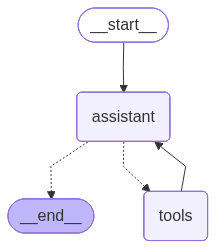

In [14]:
# Visualize the agent graph
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START → assistant → [conditional] → tools → assistant → END")

In [15]:
def interactives_chat(thread_id: str):
    print("🤖 Interactive Chat (Notebook Mode)")
    print("Type 'exit' to quit\n")

    while True:
        user_input = input("👤 You: ").strip()

        if user_input.lower() in ["exit", "quit"]:
            display(Markdown("👋 **Goodbye!**"))
            break

        if not user_input:
            continue

        # Show user message
        display(Markdown(f"**👤 You:** {user_input}"))

        # Show thinking indicator
        thinking_display = display(
            Markdown("🤖 *Agent is thinking…*"),
            display_id=True
        )

        # Invoke agent
        result = agent.invoke(
            {"messages": [HumanMessage(content=user_input)]},
            config={"configurable": {"thread_id": thread_id}}
        )

        agent_message = next(
            msg for msg in reversed(result["messages"])
            if isinstance(msg, AIMessage)
        )

        # Update thinking indicator with final response
        thinking_display.update(
            Markdown(f"**🤖 Agent:** {agent_message.content}")
        )

interactives_chat("interactive_session1")

🤖 Interactive Chat (Notebook Mode)
Type 'exit' to quit



**👤 You:** what is lagos weather

**🤖 Agent:** The weather in Lagos is currently 29°C with partly cloudy conditions and a humidity level of 78%.

**👤 You:** what is ogun state weather now

**🤖 Agent:** The weather in Ogun State is currently 25°C with clear conditions and a humidity level of 65%.

**👤 You:** what about Ekiti state

**🤖 Agent:** The weather in Ekiti State is currently 25°C with clear conditions and a humidity level of 65%.

👋 **Goodbye!**